In [2]:
import pandas as pd # data analysis and manipulation tool
import numpy as np # Numerical computing tools
import seaborn as sns  # visualization library
import matplotlib.pyplot as plt  # another visualization library
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from collections import Counter


In [3]:
df = pd.read_csv('input_ds_ready/features_rdy.csv', sep=',', header=0)
X = df.drop(['Disease'], axis=1).values
labels_true = list(df["Disease"])

X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(X, labels_true, test_size=0.15, random_state=42)

# Binary Classification
## NO/YES virus

In [4]:
print('Resampled dataset shape %s' % Counter(labels_true))

Resampled dataset shape Counter({5.0: 3455, 3.0: 1849, 0.0: 1486, 1.0: 1388, 2.0: 467, 4.0: 355})


In [5]:
labels_bin = [ 0 if label<5 else 1 for label in labels_true ]
print('Resampled dataset shape %s' % Counter(labels_bin))

Resampled dataset shape Counter({0: 5545, 1: 3455})


In [6]:
X_bin, y_bin = X, labels_bin #binary dataset


In [7]:
from imblearn.combine import SMOTETomek 
from collections import Counter
from sklearn.model_selection import train_test_split


sm = SMOTETomek(random_state=42)

X_bin_res, y_bin_res = sm.fit_resample(X, labels_bin) #up-sample
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_bin_res, y_bin_res, test_size=0.2, random_state=42) #train test split


In [8]:
print('Resampled dataset shape %s' % Counter(y_bin_res))

Resampled dataset shape Counter({0: 5265, 1: 5265})


In [9]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


bdt = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=4),
    n_estimators=1000,
    learning_rate=.09)
bdt.fit(X_bin_train, y_bin_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=0.09, n_estimators=1000)

In [10]:
y_true, y_pred = y_bin_test, bdt.predict(X_bin_test)

## **Classification Report**

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=['0','1']))


              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1054
           1       0.89      0.91      0.90      1052

    accuracy                           0.90      2106
   macro avg       0.90      0.90      0.90      2106
weighted avg       0.90      0.90      0.90      2106



In [12]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true, bdt.predict_proba(X_bin_test)[:, 1])

0.961855433943478

## Ensemble for Binary Classification

In [15]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

clf1 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=4),
    n_estimators=1000,
    learning_rate=.09)
clf2 = MLPClassifier(random_state=1, hidden_layer_sizes=(25),max_iter=5000)
clf3 = GaussianNB()

eclf1 = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
eclf1 = eclf1.fit(X_bin_train, y_bin_train)


eclf2 = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
        voting='soft')
eclf2 = eclf2.fit(X_bin_train, y_bin_train)

eclf3 = VotingClassifier(estimators=[
       ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
       voting='soft', weights=[2,1,1],
       flatten_transform=True)
eclf3 = eclf3.fit(X_bin_train, y_bin_train)


In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_bin_test, eclf1.predict(X_bin_test), target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.88      0.66      0.75      1054
           1       0.73      0.91      0.81      1052

    accuracy                           0.78      2106
   macro avg       0.80      0.78      0.78      2106
weighted avg       0.80      0.78      0.78      2106



array([0, 0, 0, ..., 1, 1, 0])

#Transfer Learning

In [409]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [410]:
model = keras.Sequential(
    [
    layers.Dense(11, activation="relu", name="layer_1",input_shape=(11,)),
    layers.Dense(150, activation="relu", name="layer_2"),
    layers.Dense(100, activation="relu", name="layer_3"),
    layers.Dense(100, activation="relu", name="layer_4"),
    layers.Dense(100, activation="relu", name="layer_5"),
    layers.Dense(50, activation="relu", name="layer_6"),
    layers.Dense(1, name="layer_7")
    ]
)



Its layers are accessible via the `layers` attribute:

In [411]:
model.layers

In [412]:
#model.weights

In [413]:
print("Number of weights after calling the model:", len(model.weights))  # 6

Number of weights after calling the model: 14


In [414]:
model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 11)                132       
_________________________________________________________________
layer_2 (Dense)              (None, 150)               1800      
_________________________________________________________________
layer_3 (Dense)              (None, 100)               15100     
_________________________________________________________________
layer_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
layer_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
layer_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
layer_7 (Dense)              (None, 1)               

###Save Model

In [415]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

###Transfer Learning Workflow

The most common incarnation of transfer learning in the context of deep learning is the following worfklow:


1.   Take layers from a previously trained model.
2.   Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4.Train the new layers on your dataset.

A last, optional step, is fine-tuning, which consists of unfreezing the entire model you obtained above (or part of it), and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data.



In [416]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [417]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(), recall_m],
)

epochs = 200
model.fit(x=np.array(X_bin_train),y=np.array(y_bin_train), epochs=epochs, validation_data=(np.array(X_bin_test), np.array(y_bin_test)))


Epoch 1/200
264/264 [==============================] - 2s 4ms/step - loss: 0.6703 - binary_accuracy: 0.5137 - recall_m: 0.0676 - val_loss: 0.6292 - val_binary_accuracy: 0.5783 - val_recall_m: 0.2366
Epoch 2/200
264/264 [==============================] - 1s 3ms/step - loss: 0.6228 - binary_accuracy: 0.5943 - recall_m: 0.2837 - val_loss: 0.5987 - val_binary_accuracy: 0.6187 - val_recall_m: 0.3421
Epoch 3/200
264/264 [==============================] - 1s 3ms/step - loss: 0.5939 - binary_accuracy: 0.6174 - recall_m: 0.3199 - val_loss: 0.5846 - val_binary_accuracy: 0.6111 - val_recall_m: 0.2608
Epoch 4/200
264/264 [==============================] - 1s 3ms/step - loss: 0.5642 - binary_accuracy: 0.6250 - recall_m: 0.3064 - val_loss: 0.5664 - val_binary_accuracy: 0.6429 - val_recall_m: 0.3764
Epoch 5/200
264/264 [==============================] - 1s 3ms/step - loss: 0.5558 - binary_accuracy: 0.6498 - recall_m: 0.4346 - val_loss: 0.5511 - val_binary_accuracy: 0.6719 - val_recall_m: 0.4679
Epoch

In [418]:
#save weights for later re-use
model.save_weights('my_weights.h5', overwrite=True)


In [419]:
#define model that fits weights
model = keras.Sequential(
    [
    layers.Dense(11, activation="relu", name="layer_1",input_shape=(11,)),
    layers.Dense(150, activation="relu", name="layer_2"),
    layers.Dense(100, activation="relu", name="layer_3"),
    layers.Dense(100, activation="relu", name="layer_4"),
    layers.Dense(100, activation="relu", name="layer_5"),
    layers.Dense(50, activation="relu", name="layer_6"),
    layers.Dense(1, name="layer_7")
    ]
)



# Presumably you would want to first load pre-trained weights.
model.load_weights('my_weights.h5')



In [420]:
#copy to another model
t_model = keras.Sequential()
for layer in model.layers[:-4]: # exclude some last layers
  t_model.add(layer)
for layer in t_model.layers:
  layer.trainable = False
t_model.add(layers.Dense(100, activation="relu", name="layer_8"))
t_model.add(layers.Dense(100, activation="relu", name="layer_20"))
t_model.add(layers.Dense(10, activation="relu", name="layer_9"))
t_model.add(layers.Dense(6, activation='softmax',name="layer_10"))


In [421]:
t_model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 11)                132       
_________________________________________________________________
layer_2 (Dense)              (None, 150)               1800      
_________________________________________________________________
layer_3 (Dense)              (None, 100)               15100     
_________________________________________________________________
layer_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
layer_20 (Dense)             (None, 100)               10100     
_________________________________________________________________
layer_9 (Dense)              (None, 10)                1010      
_________________________________________________________________
layer_10 (Dense)             (None, 6)               

In [422]:
from sklearn.preprocessing import OneHotEncoder #one-hot encode 
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.array(y_res_train).reshape(-1,1))
y_train_enc = enc.transform(np.array(y_res_train).reshape(-1,1)).toarray()
y_test_enc = enc.transform(np.array(y_test).reshape(-1,1)).toarray()

In [423]:
# Recompile and train (this will only update the weights of non-first layers.
t_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy(), recall_m],
)

epochs = 250
history2 = t_model.fit(x=np.array(X_res_train),y=np.array(y_train_enc), epochs=epochs, validation_data=(np.array(X_test), np.array(y_test_enc)))


Epoch 1/250
512/512 [==============================] - 2s 2ms/step - loss: 1.0959 - categorical_accuracy: 0.5688 - recall_m: 0.3710 - val_loss: 0.9337 - val_categorical_accuracy: 0.6350 - val_recall_m: 0.4879
Epoch 2/250
512/512 [==============================] - 1s 2ms/step - loss: 0.7687 - categorical_accuracy: 0.7135 - recall_m: 0.5838 - val_loss: 0.8981 - val_categorical_accuracy: 0.6528 - val_recall_m: 0.5203
Epoch 3/250
512/512 [==============================] - 1s 2ms/step - loss: 0.7270 - categorical_accuracy: 0.7226 - recall_m: 0.6006 - val_loss: 0.8510 - val_categorical_accuracy: 0.6667 - val_recall_m: 0.5636
Epoch 4/250
512/512 [==============================] - 1s 2ms/step - loss: 0.6887 - categorical_accuracy: 0.7437 - recall_m: 0.6317 - val_loss: 0.8321 - val_categorical_accuracy: 0.6678 - val_recall_m: 0.5609
Epoch 5/250
512/512 [==============================] - 1s 2ms/step - loss: 0.6680 - categorical_accuracy: 0.7451 - recall_m: 0.6449 - val_loss: 0.8109 - val_categor

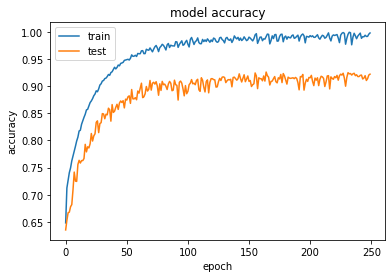

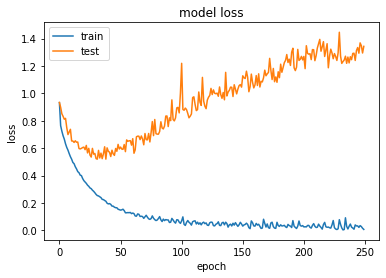

In [424]:
  # summarize history for accuracy
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()